# Entrega: secuencia más probable en una cadena de Markov.

Se pide determinar la __secuencia más verosímil__ para el modelo de Markov parametrizado en la primera sección de la práctica. La secuencia debe tener una longitud de $N=20$ aminoácidos.

Recomendación: es mejor trabajar con sumas de logaritmos de probabilidades a productos de probabilidades.

Una vez que hayas implementado el método, calcula la log-verosimilitud de la secuencia obtenida con la función myloglik y compara con las verosimilitudes obtenidas en el ejercicio 6 de la primera parte. 

¿Da alguna información la secuencia obtenida con el modelo de Markov sin variables ocultas?

## Teoría: secuencia de estados más verosímil

¿Cuál es la secuencia $\mathcal{S}=\{e_1,e_2,\ldots,e_n\}$ que __maximiza__ la verosimilitud $\log\mathbb{P}\{\mathcal{S}\}$?

### Ejemplo sencillo

Dada una cadena de Markov con dos estados posibles $\{H,P\}$, con vector de estados iniciales 

$$\mathbf{v}_0 =\left(\stackrel{H}{0.6},\quad 
\stackrel{P}{0.4}
\right)
$$

y matriz de transición 

$$P_t=
\begin{matrix}
H \\P
\end{matrix}
\stackrel{H\quad P}{%
    \begin{bmatrix}
    0.6 & 0.4 \\
    0.3 & 0.7 
    \end{bmatrix}%
  }
$$

__Método de la fuerza bruta__: una posible aproximación sería calcular, usando la teoría que ya conocemos, la verosimilitud de __todas__ las posibles cadenas que podemos formar y elegir aquella con la mayor probabilidad de ocurrir. 

En este caso tenemos 2 estados posibles y 3 pasos, por tanto el número de posibilidades son $2^3=8$, que son:

* $H-H-H$
* $H-H-P$
* $H-P-H$
* $H-P-P$
* $P-H-H$
* $P-H-P$
* $P-P-H$
* $P-P-H$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def myloglik(vecProbInicial, matrizTransicion, alfa, secuencia):
    
    loglik = 0.0
    
    primeraLetra = secuencia[0]
    primeraPosicionEnAlfabeto = alfa.index(primeraLetra)
    
    loglik += np.log(vecProbInicial[primeraPosicionEnAlfabeto])
    
    for i in range(len(secuencia)-1):
        
        letraEntrada = secuencia[i]
        letraSalida = secuencia[i+1]
        
        posicionLetraEntradaAlfabeto = alfa.index(letraEntrada)
        posicionLetraSalidaAlfabeto = alfa.index(letraSalida)
        probabilidadTransicion = matrizTransicion.iloc[posicionLetraEntradaAlfabeto,
                                                 posicionLetraSalidaAlfabeto]
        
        loglik += np.log(probabilidadTransicion)
    return loglik

In [2]:
c1 = 'HHH'
c2 = 'HHP'
c3 = 'HPH'
c4 = 'HPP'
c5 = 'PHH'
c6 = 'PHP'
c7 = 'PPH'
c8 = 'PPP'
allComb = [c1,c2,c3,c4,c5,c6,c7,c8]

In [3]:
alfabeto = [ele for ele in "HP"]
vecProbInicial = np.array((0.6,0.4))
MT = pd.DataFrame(np.array([[0.6, 0.4],[0.3, 0.7]]),index=alfabeto,columns=alfabeto)
logliks = []
for cc in allComb:
    loglik = myloglik(vecProbInicial, MT, alfabeto, cc)
    logliks.append(loglik)

res = dict(zip(allComb,logliks))
res

{'HHH': -1.5324768712979722,
 'HHP': -1.9379419794061366,
 'HPH': -2.6310891599660815,
 'HPP': -1.783791299578878,
 'PHH': -2.6310891599660815,
 'PHP': -3.036554268074246,
 'PPH': -2.4769384801388235,
 'PPP': -1.62964061975162}

In [4]:
MaxVerosimilitud = max(list(res.values()))

In [5]:
print(list(res.keys())[list(res.values()).index(MaxVerosimilitud)])

HHH


Podemos ordenar las cadenas según probabilidad en un gráfico.

In [6]:
res2 = dict(zip(allComb,np.exp(logliks)))
res2

{'HHH': 0.21599999999999997,
 'HHP': 0.144,
 'HPH': 0.07200000000000002,
 'HPP': 0.168,
 'PHH': 0.07200000000000002,
 'PHP': 0.048,
 'PPH': 0.084,
 'PPP': 0.19599999999999995}

In [7]:
index = np.argsort(np.exp(logliks))
indexDecreasing = index[::-1]
labels = np.asarray(allComb)[indexDecreasing]
vectorLikelihoodsDecreciente = np.exp(logliks)[indexDecreasing]

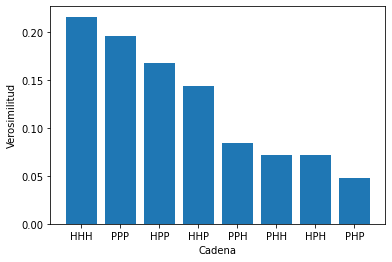

In [8]:
plt.bar(np.arange(len(vectorLikelihoodsDecreciente)),vectorLikelihoodsDecreciente)
plt.xticks(np.arange(len(vectorLikelihoodsDecreciente)),labels)
plt.xlabel('Cadena')
plt.ylabel('Verosimilitud')
plt.show()

## Programación dinámica

No obstante, el número de cadenas crece exponencialmente con la longitud de la cadena, siendo la base del exponente el número posible de estados. Para el caso del ejercicio, el número de posibles cadenas es:

* número de estados = 20 $\leftarrow$ número de AminoÁcidos
* número de pasos = 20 $\leftarrow$ longitud de la cadena
* número de casos posibles = $20^{20}$


In [9]:
20**20

104857600000000000000000000

Es por esta razón que debemos usar estrategias para reducir el número de casos a evaluar. En este caso usaremos la [__programación dinámica__](https://en.wikipedia.org/wiki/Dynamic_programming).

Veamos cómo resolver el problema anterior usando esta técnica. Vamos a ir calculando las verosimilitudes de las cadenas que van apareciendo y eliminaremos las cadenas cuya probabilidad sea menor.

Empezamos con el primer estado:

$$
\mathbf{v}_0=\left(\stackrel{H}{0.6},\quad 
\stackrel{C}{0.4}
\right),\quad
P_t=
\begin{matrix}
H \\C
\end{matrix}
\stackrel{H\quad C}{%
    \begin{bmatrix}
    0.6 & 0.4 \\
    0.3 & 0.7 
    \end{bmatrix}%
  }
$$



Las dos cadenas posibles de longitud 1 son 

* $H$
* $C$

cuyas probabilidades vienen dadas por el vector $\mathbf{v}_0$:

:::{figure-md} markdown-fig.4.08.1
<img src="./images/mm1.png" width="600px">

Cadena de Markov con dos estados. Probabilidades iniciales.
:::

En el paso 2 tenemos 4 posibles cadenas:

* $H-H$
* $H-C$
* $C-H$
* $C-C$

Para calcular las verosimilitudes de dichas cadenas usamos:

* las verosimiludes de la cadena en el paso anterior (paso 1): $\mathcal{L}_1$ que se corresponden a la probabilidad de las cadenas $H$ y $C$,
* la matriz de transición $P_t$.

Por ejemplo, para la cadena $H-H$ su verosimilitud es:

$$
\mathcal{L_1}(H)\cdot P_t(H\rightarrow H) = 0.6\times 0.6  =0.36.
$$


$$
\mathcal{L}_1=\left(
\stackrel{
{\color{red}H}
}
{
{\color{red}{0.6}}
}
,\quad 
\stackrel{C}{0.4}
\right),\quad
P_t=
\begin{matrix}
{\color{red}H} \\C
\end{matrix}
\stackrel{{\color{red}H}\quad C}{%
    \begin{bmatrix}
    {\color{red}{0.6}} & 0.4 \\
    0.3 & 0.7 
    \end{bmatrix}%
  }
$$

:::{figure-md} markdown-fig.4.08.2
<img src="./images/mm2.png" width="600px">

Cadena de Markov con dos estados. Cálculo de verosimilitudes en la etapa 2. En rojo señalada la verosimilitud de la cadena $H-H$.
:::

para la cadena $H-P$ su verosimilitud es:

$$
\mathcal{L_1}(H)\cdot P_t(H\rightarrow P) = 0.6\times 0.4  =0.24.
$$




$$
\mathcal{L}_1=\left(
\stackrel{
{\color{red}H}
}
{
{\color{red}{0.6}}
}
,\quad 
\stackrel{C}{0.4}
\right),\quad
P_t=
\begin{matrix}
{\color{red}H} \\C
\end{matrix}
\stackrel{H\quad {\color{red}C}}{%
    \begin{bmatrix}
    0.6 & {\color{red}{0.4}} \\
    0.3 & 0.7 
    \end{bmatrix}%
  }
$$

:::{figure-md} markdown-fig.4.08.3
<img src="./images/mm3.png" width="600px">

En rojo señalada la verosimilitud de la cadena $H-C$.
:::

De igual modo calculamos las verosimilitudes de las otras dos cadenas restantes:

* Cadena $P-H$

$$
\mathcal{L_1}(P)\cdot P_t(P\rightarrow H) = 0.4\times 0.3  =0.12.
$$

* Cadena $P-P$

$$
\mathcal{L_1}(P)\cdot P_t(P\rightarrow P) = 0.4\times 0.7  =0.28.
$$

En la segunda etapa, al nodo $H$ llegan dos flechas, que se corresponden con dos posibles cadenas que __acaban__ en $H$ en dicha etapa. Una de ellas, $H-H$, tiene una probabilidad de ocurrir igual a 0.36, mientras que la otra, $P-H$, tiene una probabilidad de ocurrir igual a 0.12.

__Independientemente__ de lo que suceda después, sea o no seleccionado el estado $H$ en la segunda etapa o no, la cadena $H-H$, ¡y las sucesivas que se construyan a partir de ella!, tendrá más probabilidad que la cadena $P-H$.

En este momento podemos _cortar_ la cadena $P-H$ y no considerarla más en la resolución del problema. Esto quiere decir, y aquí radica la potencia de este método, que no consideraremos todas las cadenas que empiecen por $P-H$.

En este caso particular, hemos eliminado las posibilidades $P-H-H$ y $P-H-P$.

De igual modo sucede en el otro nodo: de las dos posibles cadenas que llegan al nodo $P$ en la segunda etapa, la cadena $P-P$ es la más verosímil. Por tanto eliminamos las cadenas $H-P-H$ y $H-P-P$.



:::{figure-md} markdown-fig.4.08.4
<img src="./images/mm4.png" width="600px">

Verosimilitudes de las cuatro cadenas posibles en la fase dos.
:::

Nos quedamos con las cadenas $H-H$ y $P-P$. Ambas tienen verosimilitudes diferentes (marcadas en los círculos), pero el proceso no ha terminado.

__Importante:__ es importante notar que en este momento no podemos rechazar la cadena $P-P$ frente a $H-H$, a pesar que su verosimilitud sea menor, ya que el proceso continua.

En la etapa 3, la última etapa, volvemos a calcular las verosimilitudes de las 4 cadenas disponibles:

* $H-H-H$
* $H-H-P$
* $P-P-H$
* $P-P-P$

:::{figure-md} markdown-fig.4.08.5
<img src="./images/mm5.png" width="600px">

Verosimilitudes de las cadenas calculadas.
:::

De modo análogo al anterior, al nodo $H$ en la tercera etapa llegan dos cadenas. Elegimos aquella con mayor probabilidad de ocurrir, que es $H-H-H$, con una probabilidad de 0.216. En el nodo $P$ elegimos la cadena $P-P-P$ que tiene una verosimilitud de 0.144.

Como hemos llegado al final del proceso, tenemos que elegir la cadena más verosímil. La verosimilitud de $H-H-H$ es mayor que la de $P-P-P$, y esa será la cadena elegida.

La cadena $H-H-H$ tiene una probabilidad de ocurrir igual a 0.216.

Comprobamos con lo obtenido con la función ``myloglik``:






In [10]:
np.exp(res['HHH'])

0.21599999999999997

In [11]:
np.exp(res['PPP'])

0.19599999999999995

## Potencia del método

El número de cadenas que tenemos que evaluar con este método (su _complejidad_) es del orden de

$$
(pasos-1)\cdot(estados)^2
$$

Para el caso del ejemplo, esto sigue siendo igual a 8. Parece que no hemos ganado nada, pero para el caso de las proteínas, este número se convierte en

$$
(20-1)\cdot 20^2
$$

In [12]:
19*20**2

7600